# Remember to check for the reproducibility of the results if  this code is used again.

# DATASET
Dataset contains 6 tile  with different images
## LEGEND
the labels are:
- Building (#3C1098)
- Land (#8429F6)
- Road (#6EC1E4)
- Vegetation (#FEDD3A)
- Water (#E2A929)
- Unlabeled (#9B9B9B)

they are encoded in exadecimal
### SOURCE
from: https://www.kaggle.com/humansintheloop/semantic-segmentation-of-aerial-imagery
'''

In [ ]:
!pip install -r /content/requirements.txt

In [ ]:
!pip install kaggle

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
!mkdir -p ~/ .kaggle

In [5]:
!cp -r /content/drive/MyDrive/kaggle.json ~/ .kaggle/

In [6]:
!chmod 600 ~/ .kaggle/kaggle.json

In [7]:
!kaggle datasets download -d humansintheloop/semantic-segmentation-of-aerial-imagery

Dataset URL: https://www.kaggle.com/datasets/humansintheloop/semantic-segmentation-of-aerial-imagery
License(s): CC0-1.0
semantic-segmentation-of-aerial-imagery.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip /content/semantic-segmentation-of-aerial-imagery.zip

In [8]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
from patchify import patchify
from PIL import Image
os.environ["SM_FRAMEWORK"] = "tf.keras"
import segmentation_models as sm


Segmentation Models: using `tf.keras` framework.


In [9]:
import tensorflow as tf
print(tf.__version__)
tf.random.set_seed(42)
np.random.seed(42)
os.environ["PYTHONHASHSEED"] = str(42)

2.12.1


In [10]:
PATH  = "/content/Semantic segmentation dataset"

In [11]:
from SemanticSegmentation_scripts.PatchesGenerator import PatchesGenerator
PATCH_GENERATOR = PatchesGenerator(256,PATH)
PATCH_GENERATOR.crop_image_creating()
PATCH_GENERATOR.crop_mask_creating()

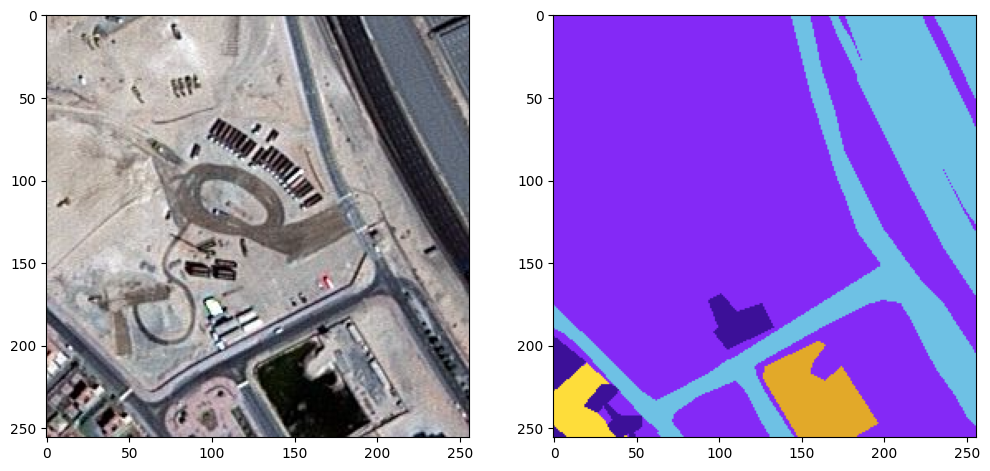

In [12]:
PATCH_GENERATOR.check()

In [13]:
from SemanticSegmentation_scripts.HEX_to_RGB import HEX_to_RGB,RGB_to_2DLabels

In [14]:
RGB_CONVERTOR = HEX_to_RGB()
HEXLabels = ["#3C1098", "#8429F6", "#6EC1E4", "#FEDD3A", "#E2A929","#9B9B9B"]
LabelsList = []
for el in HEXLabels:
    LabelsList.append(RGB_CONVERTOR.convert(el))

In [15]:
LabelsList

[array([ 60,  16, 152]),
 array([132,  41, 246]),
 array([110, 193, 228]),
 array([254, 221,  58]),
 array([226, 169,  41]),
 array([155, 155, 155])]

In [16]:
LABEL_CONVERTOR = RGB_to_2DLabels(LabelsList)
mask_dataset = PATCH_GENERATOR.mask_dataset
image_dataset = PATCH_GENERATOR.image_dataset

In [17]:
labels = []
for i in range(mask_dataset.shape[0]):
    label = LABEL_CONVERTOR.convert(mask_dataset[i])
    labels.append(label)

labels = np.array(labels)
labels = np.expand_dims(labels, axis=3)

In [18]:
print("Unique labels in label dataset are: ", np.unique(labels))

Unique labels in label dataset are:  [0 1 2 3 4 5]


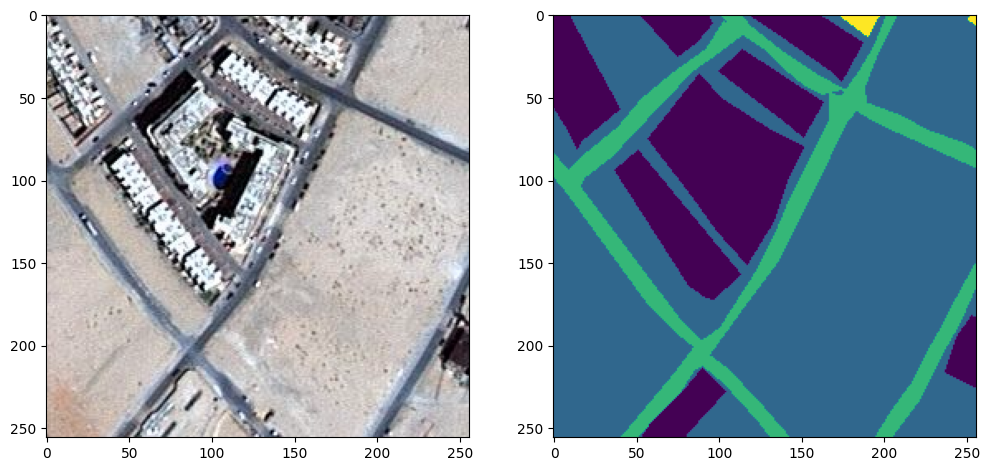

In [19]:
import random
import numpy as np
image_number = random.randint(0, len(image_dataset))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(image_dataset[image_number])
plt.subplot(122)
plt.imshow(labels[image_number][:,:,0])
plt.show()

# Modelling section

In [20]:
n_classes = len(np.unique(labels))
from tensorflow.keras.utils import to_categorical
labels_cat = to_categorical(labels, num_classes=n_classes)

In [21]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_dataset, labels_cat, test_size = 0.20, random_state = 42)

Let's create another splitting for the hyperparameters

In [22]:
X_train2, X_val, y_train2, y_val = train_test_split(X_train, y_train, test_size = 0.20, random_state = 42)

# Choosing hyperparameters

1. Check initial Loss (Turn off weight decay, sanity check loss at initialization)
2. Overfit a small sample (try to train to 100% training accuracy on a small sample of training data, approx. 5-10 minibatches)
    1. Fiddle with architecture, learning rate, weight initialization;
    2. some common problems:
        1. Loss is not going down: LR too low, or bad initialization;
        2. Loss explodes to Inf or Nan: LR too high, bad initialization
3. Use all the training data, turn on small weight decay, find the learning rate that makes the loss drop significantly  withing 100 iterations ( use the same architecture obtained in the previous step);
    1. good learning rates to try: 1e-1, 1e-2, 1e-3, 1e-4
4. choose few values of learning rate and weight decay around what worked for the previous step and then train these few models for 1-5 epochs
    1. good weight decay to try: 1e-4, 1e-5, 0
5. Pick the best models from Step 4, train them for longer 10-20 epochs WITHOUT learning rate decay.
6. Measure their performances using loss and accuracy curves
  1. Accuracy is still going up, train the models more;
  2. Huge train/ val gap means overfiiting: increase regularization or more data
  3. No gap betwee train/val means underfitting: train longer or a bigger model
7. Go back to step 5 if needed (train again with the little updates on the architecture, no need to go back to 1 since i have already a good starting point when i reached 5)

In [24]:
_, sample_imgs, y_, sample_labels = train_test_split(X_train, y_train, test_size = 0.005, random_state = 42)

In [25]:
from SemanticSegmentation_scripts.Multi_unet_model import multi_unet_model, jacard_coef

IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]


1. Check initial loss

In [ ]:
model = multi_unet_model()
model.compile(optimizer='adam', loss=sm.losses.CategoricalFocalLoss(), metrics=["accuracy"])
history1 = model.fit(X_train, y_train,
                    batch_size = 32,
                    verbose=1,
                    epochs=1,
                    shuffle=False)

In [ ]:
tf.keras.backend.clear_session()

2. Overfit a small sample

In [ ]:
sample_imgs.shape

(6, 256, 256, 3)

In [ ]:
model = multi_unet_model()
model.compile(optimizer='adam', loss=sm.losses.CategoricalFocalLoss(), metrics=["accuracy"])
history2 = model.fit(sample_imgs, sample_labels,
                    batch_size = 32,
                    verbose=1,
                    epochs=1000,
                    shuffle=False)

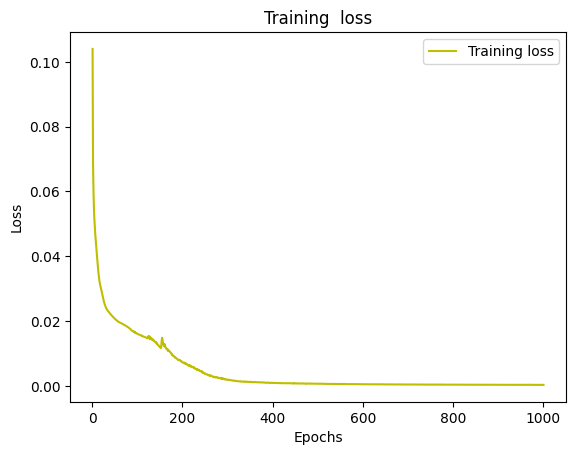

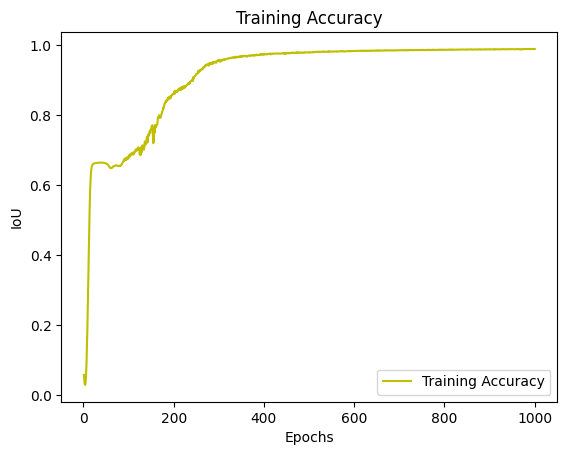

In [ ]:
history = history2
loss = history.history['loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.title('Training  loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']

plt.plot(epochs, acc, 'y', label='Training Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend()
plt.show()

3. Grid-Search (for 100 iterations). Find the set of hyperparameters that make the loss drop significantly

In [ ]:
X_train.shape

(1044, 256, 256, 3)

In [ ]:
X_train2.shape

(835, 256, 256, 3)

In [ ]:
import math
# dividing by 2 due to the cv
num_samples = 835
batch_size = 32

# Calculate the number of epochs to reach the total iterations
batches_per_epoch = math.ceil(num_samples / batch_size) # this is equal to the number of iteration in a epoch
batches_per_epoch

27

In [27]:
# Function used for Grid-search
def define_model(optimizer):
    model = multi_unet_model()
    model.compile(optimizer = optimizer, loss=sm.losses.CategoricalFocalLoss(), metrics=['accuracy'])
    return model


We can't use keras wrapper and grid search here due to shape constraints.

In fact, it is thought for 1D input/output.

We need to do sth else here!
https://adriangb.com/scikeras/stable/notebooks/DataTransformers.html

In [ ]:
import gc
import wandb
# WandbCallback will automatically log history data from any metrics collected by keras: loss and anything passed into keras_model.compile().
from wandb.integration.keras import WandbCallback
from sklearn.model_selection import ParameterGrid

param_grid = {
    'optimizer': ["adam"],
    'optimizer__learning_rate': [1e-1, 1e-2, 1e-3, 1e-4],
}

results = []
NAME = "GRID_SEARCH_STEP3_"
for params in ParameterGrid(param_grid):
    print("Training with params:", params)

    #########################################################################################
    wandb.init(project="SemanticSegmentationProject",
               name = NAME + str(params),
               reinit=True,
               )
    #########################################################################################
    if params["optimizer"] == "adam":
      optimizer = tf.keras.optimizers.Adam(learning_rate=params['optimizer__learning_rate'])
    #########################################################################################
    model = define_model(optimizer=optimizer)
    # Fit the model
    model.fit(X_train2, y_train2,validation_data = (X_val, y_val), epochs=3, batch_size=32, verbose=1,callbacks=[WandbCallback()])
    wandb.finish()
    #########################################################################################

    # Clear the Keras/TensorFlow session to free up resources
    tf.keras.backend.clear_session()
    gc.collect()


4. choose few values of learning rate and weight decay around what worked for the previous step and then train these few models for 1-5 epochs

In [ ]:
learning_rate = 0.001 # Chosen lr
multipliers = [0.5, 0.80, 1.0, 1.25, 1.5]

learning_rates = [learning_rate * m for m in multipliers]

learning_rates

[0.0005, 0.0008, 0.001, 0.00125, 0.0015]

In [ ]:
param_grid = {
    'optimizer': ["adam"],
    'optimizer__learning_rate': learning_rates,
}

results = []
NAME = "GRID_SEARCH_STEP4_"
for params in ParameterGrid(param_grid):
    print("Training with params:", params)

    #########################################################################################
    wandb.init(project="SemanticSegmentationProject",
               name = NAME + str(params),
               reinit=True,
               )
    #########################################################################################
    if params["optimizer"] == "adam":
      optimizer = tf.keras.optimizers.Adam(learning_rate=params['optimizer__learning_rate'])
    #########################################################################################
    model = define_model(optimizer=optimizer)
    # Fit the model
    model.fit(X_train, y_train,validation_data = (X_val, y_val), epochs=5, batch_size=32, verbose=1,callbacks=[WandbCallback()])
    wandb.finish()
    #########################################################################################

    # Clear the Keras/TensorFlow session to free up resources
    tf.keras.backend.clear_session()
    gc.collect()


5. Pick the best models from Step 4, train them for longer 10-20 epochs WITHOUT learning rate decay.

In [ ]:
param_grid = {
    'optimizer': ["adam"],
    'optimizer__learning_rate': [0.0015,0.00125],
}

results = []
NAME = "GRID_SEARCH_STEP5_"
for params in ParameterGrid(param_grid):
    print("Training with params:", params)

    #########################################################################################
    wandb.init(project="SemanticSegmentationProject",
               name = NAME + str(params),
               reinit=True,
               )
    #########################################################################################
    if params["optimizer"] == "adam":
      optimizer = tf.keras.optimizers.Adam(learning_rate=params['optimizer__learning_rate'])
    #########################################################################################
    model = define_model(optimizer=optimizer)
    # Fit the model
    model.fit(X_train, y_train,validation_data = (X_val, y_val), epochs=20, batch_size=32, verbose=1,callbacks=[WandbCallback()])
    wandb.finish()
    #########################################################################################

    # Clear the Keras/TensorFlow session to free up resources
    tf.keras.backend.clear_session()
    gc.collect()

6. Let's measure the performances and decide if we need to train longer or to change the architecture a little bit and go back to step 5

In [ ]:
from SemanticSegmentation_scripts.Multi_unet_model import multi_unet_model, jacard_coef

lr = 0.00125
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
model = define_model(optimizer=optimizer)
history_final = model.fit(X_train, y_train,validation_data = (X_val, y_val), epochs=20, batch_size=32, verbose=1)

In [29]:
model.save("my_model.h5")

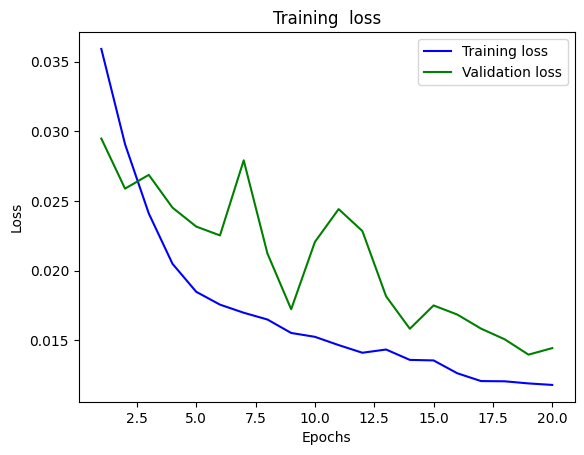

In [30]:
history = history_final
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'g', label='Validation loss')

plt.title('Training  loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

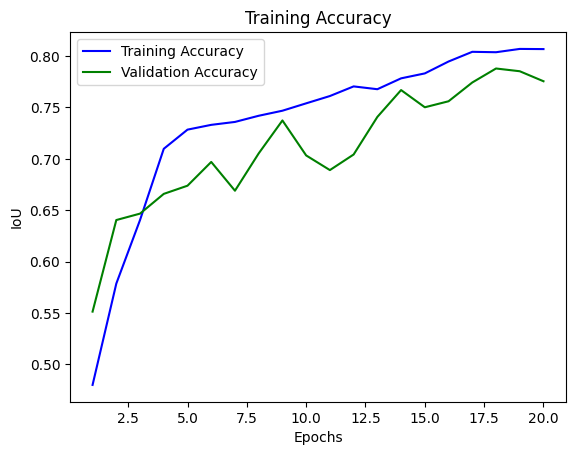

In [31]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']


plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'g', label='Validation Accuracy')

plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend()
plt.show()

In [32]:
y_pred=model.predict(X_test)
y_pred_argmax=np.argmax(y_pred, axis=3)
y_test_argmax=np.argmax(y_test, axis=3)

#Using built in keras function for IoU
from keras.metrics import MeanIoU
n_classes = 6
IOU_keras = MeanIoU(num_classes=n_classes)
IOU_keras.update_state(y_test_argmax, y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())


9/9 [==============================] - 5s 488ms/step
Mean IoU = 0.4816024


In [35]:
img = X_test[6]
test_img_input=np.expand_dims(img, 0)

In [36]:
prediction = (model.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]

1/1 [==============================] - 0s 66ms/step


In [43]:
y_test_argmax=np.argmax(y_test, axis=3)

Let's just show a pair to see how good the model is

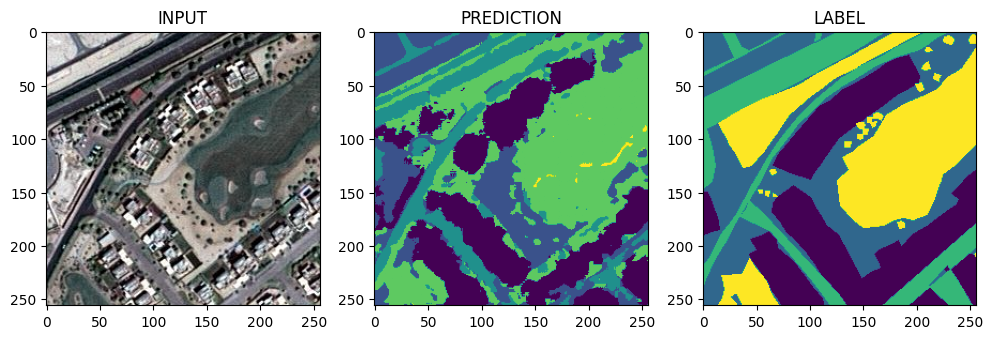

In [50]:
plt.figure(figsize = (12,8))
plt.subplot(1,3,1)
plt.imshow(X_test[6])
plt.title("INPUT")

plt.subplot(1,3,2)
plt.imshow(predicted_img)
plt.title("PREDICTION")
plt.subplot(1,3,3)
gt_mask=y_test_argmax[6]
plt.imshow(gt_mask)
plt.title("LABEL")
plt.show()